In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn import metrics

import time
import os
import cv2

img_height = 64
img_width = 64
batch_size = 32

In [160]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='training_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 5064 files belonging to 2 classes.


In [161]:
val_ds = keras.utils.image_dataset_from_directory(
    directory='validation_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 967 files belonging to 2 classes.


In [226]:
test_ds = keras.utils.image_dataset_from_directory(
    directory='test_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 564 files belonging to 2 classes.


In [163]:
all_ds = keras.utils.image_dataset_from_directory(
    directory='tiles/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 114216 files belonging to 2 classes.


In [164]:
class_names = train_ds.class_names
print(class_names)

['defect', 'normal']


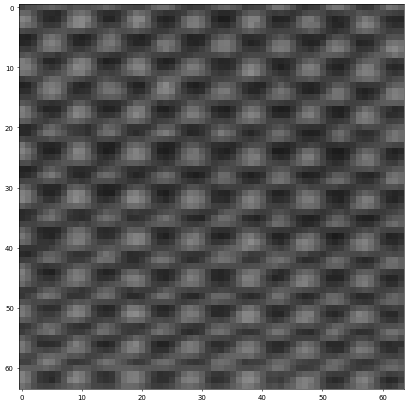

tf.Tensor(
[[[ 68.  68.  68.]
  [ 78.  78.  78.]
  [ 80.  80.  80.]
  ...
  [115. 115. 115.]
  [109. 109. 109.]
  [ 98.  98.  98.]]

 [[102. 102. 102.]
  [100. 100. 100.]
  [ 79.  79.  79.]
  ...
  [ 68.  68.  68.]
  [ 63.  63.  63.]
  [ 60.  60.  60.]]

 [[132. 132. 132.]
  [123. 123. 123.]
  [ 91.  91.  91.]
  ...
  [ 42.  42.  42.]
  [ 39.  39.  39.]
  [ 38.  38.  38.]]

 ...

 [[129. 129. 129.]
  [111. 111. 111.]
  [ 83.  83.  83.]
  ...
  [ 61.  61.  61.]
  [ 64.  64.  64.]
  [ 69.  69.  69.]]

 [[129. 129. 129.]
  [115. 115. 115.]
  [ 82.  82.  82.]
  ...
  [ 39.  39.  39.]
  [ 42.  42.  42.]
  [ 59.  59.  59.]]

 [[113. 113. 113.]
  [101. 101. 101.]
  [ 79.  79.  79.]
  ...
  [ 54.  54.  54.]
  [ 61.  61.  61.]
  [ 79.  79.  79.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


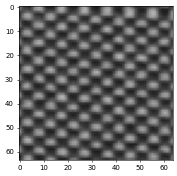

tf.Tensor(
[[[115. 115. 115.]
  [ 75.  75.  75.]
  [ 56.  56.  56.]
  ...
  [ 88.  88.  88.]
  [ 63.  63.  63.]
  [ 65.  65.  65.]]

 [[105. 105. 105.]
  [ 77.  77.  77.]
  [ 73.  73.  73.]
  ...
  [ 33.  33.  33.]
  [ 52.  52.  52.]
  [ 87.  87.  87.]]

 [[ 63.  63.  63.]
  [ 76.  76.  76.]
  [ 91.  91.  91.]
  ...
  [ 32.  32.  32.]
  [ 73.  73.  73.]
  [130. 130. 130.]]

 ...

 [[ 61.  61.  61.]
  [ 70.  70.  70.]
  [ 75.  75.  75.]
  ...
  [ 55.  55.  55.]
  [ 61.  61.  61.]
  [ 72.  72.  72.]]

 [[ 37.  37.  37.]
  [ 81.  81.  81.]
  [125. 125. 125.]
  ...
  [ 34.  34.  34.]
  [ 48.  48.  48.]
  [101. 101. 101.]]

 [[ 48.  48.  48.]
  [ 92.  92.  92.]
  [138. 138. 138.]
  ...
  [ 54.  54.  54.]
  [ 58.  58.  58.]
  [104. 104. 104.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


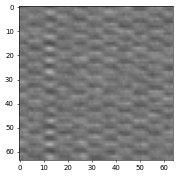

tf.Tensor(
[[[105. 105. 105.]
  [106. 106. 106.]
  [107. 107. 107.]
  ...
  [109. 109. 109.]
  [113. 113. 113.]
  [113. 113. 113.]]

 [[129. 129. 129.]
  [124. 124. 124.]
  [128. 128. 128.]
  ...
  [105. 105. 105.]
  [102. 102. 102.]
  [103. 103. 103.]]

 [[122. 122. 122.]
  [123. 123. 123.]
  [126. 126. 126.]
  ...
  [138. 138. 138.]
  [127. 127. 127.]
  [127. 127. 127.]]

 ...

 [[134. 134. 134.]
  [136. 136. 136.]
  [123. 123. 123.]
  ...
  [111. 111. 111.]
  [104. 104. 104.]
  [ 99.  99.  99.]]

 [[120. 120. 120.]
  [117. 117. 117.]
  [126. 126. 126.]
  ...
  [131. 131. 131.]
  [118. 118. 118.]
  [131. 131. 131.]]

 [[116. 116. 116.]
  [110. 110. 110.]
  [122. 122. 122.]
  ...
  [129. 129. 129.]
  [127. 127. 127.]
  [127. 127. 127.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


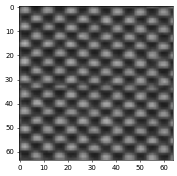

tf.Tensor(
[[[ 87.  87.  87.]
  [123. 123. 123.]
  [137. 137. 137.]
  ...
  [ 82.  82.  82.]
  [ 96.  96.  96.]
  [113. 113. 113.]]

 [[111. 111. 111.]
  [141. 141. 141.]
  [159. 159. 159.]
  ...
  [106. 106. 106.]
  [ 73.  73.  73.]
  [ 55.  55.  55.]]

 [[106. 106. 106.]
  [126. 126. 126.]
  [139. 139. 139.]
  ...
  [129. 129. 129.]
  [ 85.  85.  85.]
  [ 48.  48.  48.]]

 ...

 [[ 68.  68.  68.]
  [ 34.  34.  34.]
  [ 32.  32.  32.]
  ...
  [ 53.  53.  53.]
  [ 58.  58.  58.]
  [ 78.  78.  78.]]

 [[ 82.  82.  82.]
  [ 53.  53.  53.]
  [ 47.  47.  47.]
  ...
  [ 32.  32.  32.]
  [ 64.  64.  64.]
  [109. 109. 109.]]

 [[ 71.  71.  71.]
  [ 63.  63.  63.]
  [ 64.  64.  64.]
  ...
  [ 47.  47.  47.]
  [ 73.  73.  73.]
  [119. 119. 119.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


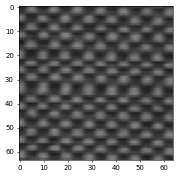

tf.Tensor(
[[[ 34.  34.  34.]
  [ 33.  33.  33.]
  [ 48.  48.  48.]
  ...
  [ 62.  62.  62.]
  [ 71.  71.  71.]
  [ 70.  70.  70.]]

 [[ 48.  48.  48.]
  [ 46.  46.  46.]
  [ 61.  61.  61.]
  ...
  [ 92.  92.  92.]
  [111. 111. 111.]
  [104. 104. 104.]]

 [[ 52.  52.  52.]
  [ 51.  51.  51.]
  [ 63.  63.  63.]
  ...
  [108. 108. 108.]
  [132. 132. 132.]
  [119. 119. 119.]]

 ...

 [[126. 126. 126.]
  [125. 125. 125.]
  [ 97.  97.  97.]
  ...
  [ 97.  97.  97.]
  [105. 105. 105.]
  [103. 103. 103.]]

 [[121. 121. 121.]
  [120. 120. 120.]
  [ 95.  95.  95.]
  ...
  [ 43.  43.  43.]
  [ 47.  47.  47.]
  [ 52.  52.  52.]]

 [[ 74.  74.  74.]
  [ 76.  76.  76.]
  [ 66.  66.  66.]
  ...
  [ 44.  44.  44.]
  [ 37.  37.  37.]
  [ 37.  37.  37.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


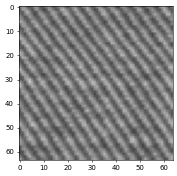

tf.Tensor(
[[[118. 118. 118.]
  [152. 152. 152.]
  [142. 142. 142.]
  ...
  [119. 119. 119.]
  [ 81.  81.  81.]
  [111. 111. 111.]]

 [[ 97.  97.  97.]
  [158. 158. 158.]
  [160. 160. 160.]
  ...
  [143. 143. 143.]
  [101. 101. 101.]
  [ 88.  88.  88.]]

 [[102. 102. 102.]
  [ 89.  89.  89.]
  [140. 140. 140.]
  ...
  [162. 162. 162.]
  [148. 148. 148.]
  [ 97.  97.  97.]]

 ...

 [[ 91.  91.  91.]
  [ 81.  81.  81.]
  [129. 129. 129.]
  ...
  [166. 166. 166.]
  [153. 153. 153.]
  [125. 125. 125.]]

 [[125. 125. 125.]
  [ 92.  92.  92.]
  [ 77.  77.  77.]
  ...
  [136. 136. 136.]
  [151. 151. 151.]
  [168. 168. 168.]]

 [[165. 165. 165.]
  [115. 115. 115.]
  [ 84.  84.  84.]
  ...
  [ 85.  85.  85.]
  [148. 148. 148.]
  [166. 166. 166.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


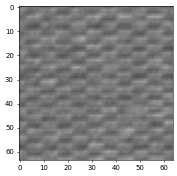

tf.Tensor(
[[[120. 120. 120.]
  [126. 126. 126.]
  [131. 131. 131.]
  ...
  [113. 113. 113.]
  [108. 108. 108.]
  [103. 103. 103.]]

 [[142. 142. 142.]
  [139. 139. 139.]
  [132. 132. 132.]
  ...
  [129. 129. 129.]
  [120. 120. 120.]
  [128. 128. 128.]]

 [[119. 119. 119.]
  [125. 125. 125.]
  [110. 110. 110.]
  ...
  [121. 121. 121.]
  [112. 112. 112.]
  [125. 125. 125.]]

 ...

 [[133. 133. 133.]
  [127. 127. 127.]
  [124. 124. 124.]
  ...
  [125. 125. 125.]
  [130. 130. 130.]
  [121. 121. 121.]]

 [[132. 132. 132.]
  [119. 119. 119.]
  [122. 122. 122.]
  ...
  [123. 123. 123.]
  [123. 123. 123.]
  [115. 115. 115.]]

 [[114. 114. 114.]
  [109. 109. 109.]
  [110. 110. 110.]
  ...
  [113. 113. 113.]
  [110. 110. 110.]
  [105. 105. 105.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


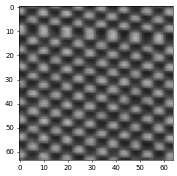

tf.Tensor(
[[[104. 104. 104.]
  [ 90.  90.  90.]
  [ 73.  73.  73.]
  ...
  [ 88.  88.  88.]
  [ 88.  88.  88.]
  [ 85.  85.  85.]]

 [[156. 156. 156.]
  [148. 148. 148.]
  [103. 103. 103.]
  ...
  [140. 140. 140.]
  [146. 146. 146.]
  [132. 132. 132.]]

 [[159. 159. 159.]
  [148. 148. 148.]
  [101. 101. 101.]
  ...
  [157. 157. 157.]
  [176. 176. 176.]
  [156. 156. 156.]]

 ...

 [[153. 153. 153.]
  [157. 157. 157.]
  [119. 119. 119.]
  ...
  [118. 118. 118.]
  [148. 148. 148.]
  [144. 144. 144.]]

 [[149. 149. 149.]
  [147. 147. 147.]
  [112. 112. 112.]
  ...
  [130. 130. 130.]
  [157. 157. 157.]
  [151. 151. 151.]]

 [[100. 100. 100.]
  [ 92.  92.  92.]
  [ 76.  76.  76.]
  ...
  [125. 125. 125.]
  [144. 144. 144.]
  [136. 136. 136.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


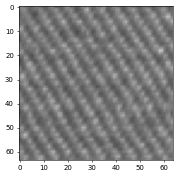

tf.Tensor(
[[[130. 130. 130.]
  [136. 136. 136.]
  [123. 123. 123.]
  ...
  [113. 113. 113.]
  [ 91.  91.  91.]
  [104. 104. 104.]]

 [[123. 123. 123.]
  [136. 136. 136.]
  [141. 141. 141.]
  ...
  [121. 121. 121.]
  [ 99.  99.  99.]
  [107. 107. 107.]]

 [[111. 111. 111.]
  [129. 129. 129.]
  [130. 130. 130.]
  ...
  [128. 128. 128.]
  [120. 120. 120.]
  [113. 113. 113.]]

 ...

 [[140. 140. 140.]
  [133. 133. 133.]
  [113. 113. 113.]
  ...
  [117. 117. 117.]
  [111. 111. 111.]
  [112. 112. 112.]]

 [[126. 126. 126.]
  [137. 137. 137.]
  [149. 149. 149.]
  ...
  [138. 138. 138.]
  [105. 105. 105.]
  [105. 105. 105.]]

 [[121. 121. 121.]
  [128. 128. 128.]
  [153. 153. 153.]
  ...
  [137. 137. 137.]
  [125. 125. 125.]
  [119. 119. 119.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


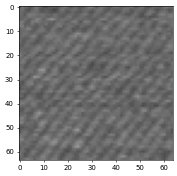

tf.Tensor(
[[[ 95.  95.  95.]
  [117. 117. 117.]
  [106. 106. 106.]
  ...
  [117. 117. 117.]
  [111. 111. 111.]
  [107. 107. 107.]]

 [[110. 110. 110.]
  [112. 112. 112.]
  [ 97.  97.  97.]
  ...
  [ 96.  96.  96.]
  [ 80.  80.  80.]
  [ 91.  91.  91.]]

 [[107. 107. 107.]
  [105. 105. 105.]
  [ 95.  95.  95.]
  ...
  [105. 105. 105.]
  [ 91.  91.  91.]
  [ 97.  97.  97.]]

 ...

 [[120. 120. 120.]
  [102. 102. 102.]
  [ 81.  81.  81.]
  ...
  [ 86.  86.  86.]
  [ 94.  94.  94.]
  [113. 113. 113.]]

 [[107. 107. 107.]
  [102. 102. 102.]
  [ 86.  86.  86.]
  ...
  [ 88.  88.  88.]
  [107. 107. 107.]
  [118. 118. 118.]]

 [[101. 101. 101.]
  [104. 104. 104.]
  [112. 112. 112.]
  ...
  [101. 101. 101.]
  [117. 117. 117.]
  [117. 117. 117.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


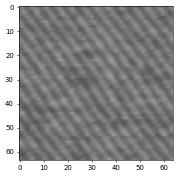

tf.Tensor(
[[[139. 139. 139.]
  [136. 136. 136.]
  [114. 114. 114.]
  ...
  [107. 107. 107.]
  [128. 128. 128.]
  [141. 141. 141.]]

 [[121. 121. 121.]
  [130. 130. 130.]
  [114. 114. 114.]
  ...
  [104. 104. 104.]
  [103. 103. 103.]
  [126. 126. 126.]]

 [[112. 112. 112.]
  [139. 139. 139.]
  [142. 142. 142.]
  ...
  [110. 110. 110.]
  [ 91.  91.  91.]
  [100. 100. 100.]]

 ...

 [[ 93.  93.  93.]
  [ 82.  82.  82.]
  [ 93.  93.  93.]
  ...
  [126. 126. 126.]
  [127. 127. 127.]
  [109. 109. 109.]]

 [[100. 100. 100.]
  [ 90.  90.  90.]
  [ 94.  94.  94.]
  ...
  [113. 113. 113.]
  [122. 122. 122.]
  [114. 114. 114.]]

 [[120. 120. 120.]
  [103. 103. 103.]
  [ 96.  96.  96.]
  ...
  [ 99.  99.  99.]
  [113. 113. 113.]
  [136. 136. 136.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


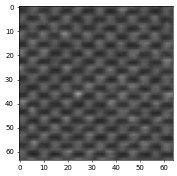

tf.Tensor(
[[[61. 61. 61.]
  [64. 64. 64.]
  [62. 62. 62.]
  ...
  [87. 87. 87.]
  [88. 88. 88.]
  [88. 88. 88.]]

 [[42. 42. 42.]
  [47. 47. 47.]
  [52. 52. 52.]
  ...
  [95. 95. 95.]
  [84. 84. 84.]
  [70. 70. 70.]]

 [[52. 52. 52.]
  [54. 54. 54.]
  [57. 57. 57.]
  ...
  [89. 89. 89.]
  [77. 77. 77.]
  [61. 61. 61.]]

 ...

 [[93. 93. 93.]
  [94. 94. 94.]
  [88. 88. 88.]
  ...
  [49. 49. 49.]
  [48. 48. 48.]
  [49. 49. 49.]]

 [[89. 89. 89.]
  [92. 92. 92.]
  [81. 81. 81.]
  ...
  [55. 55. 55.]
  [53. 53. 53.]
  [59. 59. 59.]]

 [[84. 84. 84.]
  [78. 78. 78.]
  [75. 75. 75.]
  ...
  [93. 93. 93.]
  [91. 91. 91.]
  [87. 87. 87.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


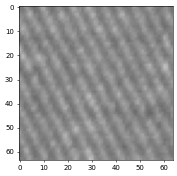

tf.Tensor(
[[[119. 119. 119.]
  [122. 122. 122.]
  [147. 147. 147.]
  ...
  [145. 145. 145.]
  [128. 128. 128.]
  [119. 119. 119.]]

 [[121. 121. 121.]
  [119. 119. 119.]
  [131. 131. 131.]
  ...
  [146. 146. 146.]
  [131. 131. 131.]
  [116. 116. 116.]]

 [[128. 128. 128.]
  [128. 128. 128.]
  [132. 132. 132.]
  ...
  [151. 151. 151.]
  [140. 140. 140.]
  [119. 119. 119.]]

 ...

 [[110. 110. 110.]
  [127. 127. 127.]
  [143. 143. 143.]
  ...
  [135. 135. 135.]
  [125. 125. 125.]
  [116. 116. 116.]]

 [[118. 118. 118.]
  [125. 125. 125.]
  [138. 138. 138.]
  ...
  [142. 142. 142.]
  [137. 137. 137.]
  [122. 122. 122.]]

 [[124. 124. 124.]
  [127. 127. 127.]
  [126. 126. 126.]
  ...
  [146. 146. 146.]
  [146. 146. 146.]
  [139. 139. 139.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


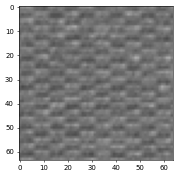

tf.Tensor(
[[[135. 135. 135.]
  [145. 145. 145.]
  [141. 141. 141.]
  ...
  [113. 113. 113.]
  [123. 123. 123.]
  [140. 140. 140.]]

 [[117. 117. 117.]
  [121. 121. 121.]
  [118. 118. 118.]
  ...
  [107. 107. 107.]
  [116. 116. 116.]
  [123. 123. 123.]]

 [[118. 118. 118.]
  [120. 120. 120.]
  [125. 125. 125.]
  ...
  [116. 116. 116.]
  [113. 113. 113.]
  [116. 116. 116.]]

 ...

 [[ 95.  95.  95.]
  [ 89.  89.  89.]
  [ 87.  87.  87.]
  ...
  [147. 147. 147.]
  [133. 133. 133.]
  [115. 115. 115.]]

 [[ 94.  94.  94.]
  [100. 100. 100.]
  [106. 106. 106.]
  ...
  [119. 119. 119.]
  [112. 112. 112.]
  [114. 114. 114.]]

 [[120. 120. 120.]
  [141. 141. 141.]
  [135. 135. 135.]
  ...
  [121. 121. 121.]
  [117. 117. 117.]
  [116. 116. 116.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


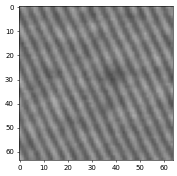

tf.Tensor(
[[[142. 142. 142.]
  [163. 163. 163.]
  [145. 145. 145.]
  ...
  [137. 137. 137.]
  [155. 155. 155.]
  [136. 136. 136.]]

 [[114. 114. 114.]
  [144. 144. 144.]
  [147. 147. 147.]
  ...
  [113. 113. 113.]
  [139. 139. 139.]
  [142. 142. 142.]]

 [[ 89.  89.  89.]
  [133. 133. 133.]
  [146. 146. 146.]
  ...
  [109. 109. 109.]
  [135. 135. 135.]
  [144. 144. 144.]]

 ...

 [[148. 148. 148.]
  [115. 115. 115.]
  [ 96.  96.  96.]
  ...
  [134. 134. 134.]
  [105. 105. 105.]
  [ 95.  95.  95.]]

 [[168. 168. 168.]
  [138. 138. 138.]
  [101. 101. 101.]
  ...
  [147. 147. 147.]
  [126. 126. 126.]
  [ 96.  96.  96.]]

 [[165. 165. 165.]
  [154. 154. 154.]
  [111. 111. 111.]
  ...
  [149. 149. 149.]
  [142. 142. 142.]
  [110. 110. 110.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


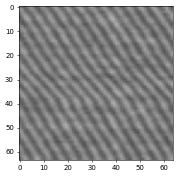

tf.Tensor(
[[[132. 132. 132.]
  [105. 105. 105.]
  [ 95.  95.  95.]
  ...
  [151. 151. 151.]
  [117. 117. 117.]
  [ 90.  90.  90.]]

 [[153. 153. 153.]
  [142. 142. 142.]
  [101. 101. 101.]
  ...
  [158. 158. 158.]
  [135. 135. 135.]
  [106. 106. 106.]]

 [[133. 133. 133.]
  [143. 143. 143.]
  [126. 126. 126.]
  ...
  [140. 140. 140.]
  [154. 154. 154.]
  [128. 128. 128.]]

 ...

 [[120. 120. 120.]
  [136. 136. 136.]
  [121. 121. 121.]
  ...
  [129. 129. 129.]
  [146. 146. 146.]
  [127. 127. 127.]]

 [[111. 111. 111.]
  [145. 145. 145.]
  [144. 144. 144.]
  ...
  [117. 117. 117.]
  [143. 143. 143.]
  [146. 146. 146.]]

 [[ 99.  99.  99.]
  [131. 131. 131.]
  [156. 156. 156.]
  ...
  [114. 114. 114.]
  [138. 138. 138.]
  [157. 157. 157.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


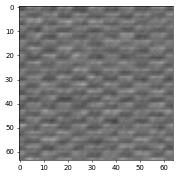

tf.Tensor(
[[[ 89.  89.  89.]
  [ 88.  88.  88.]
  [ 99.  99.  99.]
  ...
  [112. 112. 112.]
  [100. 100. 100.]
  [110. 110. 110.]]

 [[ 85.  85.  85.]
  [ 77.  77.  77.]
  [ 93.  93.  93.]
  ...
  [ 92.  92.  92.]
  [ 84.  84.  84.]
  [ 84.  84.  84.]]

 [[113. 113. 113.]
  [122. 122. 122.]
  [121. 121. 121.]
  ...
  [118. 118. 118.]
  [116. 116. 116.]
  [124. 124. 124.]]

 ...

 [[129. 129. 129.]
  [139. 139. 139.]
  [120. 120. 120.]
  ...
  [129. 129. 129.]
  [132. 132. 132.]
  [128. 128. 128.]]

 [[113. 113. 113.]
  [106. 106. 106.]
  [101. 101. 101.]
  ...
  [112. 112. 112.]
  [112. 112. 112.]
  [110. 110. 110.]]

 [[108. 108. 108.]
  [104. 104. 104.]
  [118. 118. 118.]
  ...
  [116. 116. 116.]
  [107. 107. 107.]
  [114. 114. 114.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


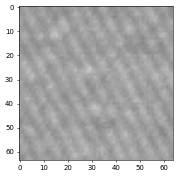

tf.Tensor(
[[[152. 152. 152.]
  [158. 158. 158.]
  [167. 167. 167.]
  ...
  [160. 160. 160.]
  [136. 136. 136.]
  [144. 144. 144.]]

 [[145. 145. 145.]
  [158. 158. 158.]
  [163. 163. 163.]
  ...
  [160. 160. 160.]
  [148. 148. 148.]
  [137. 137. 137.]]

 [[148. 148. 148.]
  [154. 154. 154.]
  [160. 160. 160.]
  ...
  [157. 157. 157.]
  [149. 149. 149.]
  [142. 142. 142.]]

 ...

 [[152. 152. 152.]
  [158. 158. 158.]
  [151. 151. 151.]
  ...
  [180. 180. 180.]
  [159. 159. 159.]
  [149. 149. 149.]]

 [[144. 144. 144.]
  [140. 140. 140.]
  [150. 150. 150.]
  ...
  [166. 166. 166.]
  [160. 160. 160.]
  [138. 138. 138.]]

 [[147. 147. 147.]
  [139. 139. 139.]
  [153. 153. 153.]
  ...
  [163. 163. 163.]
  [156. 156. 156.]
  [159. 159. 159.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


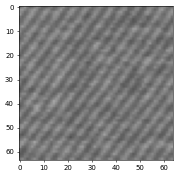

tf.Tensor(
[[[112. 112. 112.]
  [130. 130. 130.]
  [147. 147. 147.]
  ...
  [119. 119. 119.]
  [108. 108. 108.]
  [113. 113. 113.]]

 [[148. 148. 148.]
  [150. 150. 150.]
  [133. 133. 133.]
  ...
  [110. 110. 110.]
  [119. 119. 119.]
  [142. 142. 142.]]

 [[142. 142. 142.]
  [132. 132. 132.]
  [107. 107. 107.]
  ...
  [119. 119. 119.]
  [138. 138. 138.]
  [149. 149. 149.]]

 ...

 [[ 91.  91.  91.]
  [ 93.  93.  93.]
  [112. 112. 112.]
  ...
  [128. 128. 128.]
  [102. 102. 102.]
  [ 99.  99.  99.]]

 [[ 98.  98.  98.]
  [104. 104. 104.]
  [122. 122. 122.]
  ...
  [111. 111. 111.]
  [105. 105. 105.]
  [111. 111. 111.]]

 [[121. 121. 121.]
  [134. 134. 134.]
  [117. 117. 117.]
  ...
  [100. 100. 100.]
  [118. 118. 118.]
  [131. 131. 131.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


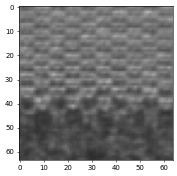

tf.Tensor(
[[[115. 115. 115.]
  [ 93.  93.  93.]
  [ 97.  97.  97.]
  ...
  [152. 152. 152.]
  [151. 151. 151.]
  [144. 144. 144.]]

 [[112. 112. 112.]
  [100. 100. 100.]
  [ 97.  97.  97.]
  ...
  [130. 130. 130.]
  [120. 120. 120.]
  [122. 122. 122.]]

 [[127. 127. 127.]
  [128. 128. 128.]
  [130. 130. 130.]
  ...
  [121. 121. 121.]
  [122. 122. 122.]
  [122. 122. 122.]]

 ...

 [[ 71.  71.  71.]
  [ 71.  71.  71.]
  [ 54.  54.  54.]
  ...
  [ 95.  95.  95.]
  [ 89.  89.  89.]
  [ 77.  77.  77.]]

 [[ 65.  65.  65.]
  [ 61.  61.  61.]
  [ 61.  61.  61.]
  ...
  [ 71.  71.  71.]
  [ 75.  75.  75.]
  [ 78.  78.  78.]]

 [[ 65.  65.  65.]
  [ 67.  67.  67.]
  [ 68.  68.  68.]
  ...
  [ 58.  58.  58.]
  [ 63.  63.  63.]
  [ 63.  63.  63.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


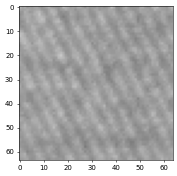

tf.Tensor(
[[[180. 180. 180.]
  [164. 164. 164.]
  [170. 170. 170.]
  ...
  [152. 152. 152.]
  [171. 171. 171.]
  [184. 184. 184.]]

 [[166. 166. 166.]
  [161. 161. 161.]
  [164. 164. 164.]
  ...
  [153. 153. 153.]
  [161. 161. 161.]
  [174. 174. 174.]]

 [[151. 151. 151.]
  [152. 152. 152.]
  [175. 175. 175.]
  ...
  [157. 157. 157.]
  [161. 161. 161.]
  [159. 159. 159.]]

 ...

 [[166. 166. 166.]
  [168. 168. 168.]
  [177. 177. 177.]
  ...
  [154. 154. 154.]
  [158. 158. 158.]
  [162. 162. 162.]]

 [[163. 163. 163.]
  [168. 168. 168.]
  [172. 172. 172.]
  ...
  [160. 160. 160.]
  [161. 161. 161.]
  [164. 164. 164.]]

 [[157. 157. 157.]
  [159. 159. 159.]
  [165. 165. 165.]
  ...
  [168. 168. 168.]
  [157. 157. 157.]
  [169. 169. 169.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


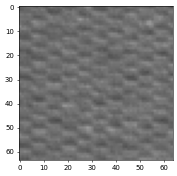

tf.Tensor(
[[[ 94.  94.  94.]
  [ 99.  99.  99.]
  [103. 103. 103.]
  ...
  [110. 110. 110.]
  [ 98.  98.  98.]
  [ 86.  86.  86.]]

 [[ 90.  90.  90.]
  [ 94.  94.  94.]
  [102. 102. 102.]
  ...
  [108. 108. 108.]
  [113. 113. 113.]
  [114. 114. 114.]]

 [[106. 106. 106.]
  [105. 105. 105.]
  [104. 104. 104.]
  ...
  [101. 101. 101.]
  [122. 122. 122.]
  [123. 123. 123.]]

 ...

 [[115. 115. 115.]
  [112. 112. 112.]
  [114. 114. 114.]
  ...
  [119. 119. 119.]
  [112. 112. 112.]
  [107. 107. 107.]]

 [[106. 106. 106.]
  [ 99.  99.  99.]
  [104. 104. 104.]
  ...
  [112. 112. 112.]
  [116. 116. 116.]
  [106. 106. 106.]]

 [[ 95.  95.  95.]
  [ 88.  88.  88.]
  [ 93.  93.  93.]
  ...
  [124. 124. 124.]
  [125. 125. 125.]
  [121. 121. 121.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


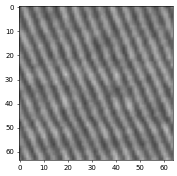

tf.Tensor(
[[[ 96.  96.  96.]
  [152. 152. 152.]
  [151. 151. 151.]
  ...
  [ 90.  90.  90.]
  [ 88.  88.  88.]
  [122. 122. 122.]]

 [[ 95.  95.  95.]
  [136. 136. 136.]
  [159. 159. 159.]
  ...
  [119. 119. 119.]
  [ 85.  85.  85.]
  [102. 102. 102.]]

 [[ 91.  91.  91.]
  [115. 115. 115.]
  [161. 161. 161.]
  ...
  [138. 138. 138.]
  [ 91.  91.  91.]
  [ 96.  96.  96.]]

 ...

 [[ 95.  95.  95.]
  [115. 115. 115.]
  [154. 154. 154.]
  ...
  [144. 144. 144.]
  [104. 104. 104.]
  [ 92.  92.  92.]]

 [[100. 100. 100.]
  [ 93.  93.  93.]
  [139. 139. 139.]
  ...
  [156. 156. 156.]
  [121. 121. 121.]
  [ 99.  99.  99.]]

 [[116. 116. 116.]
  [ 87.  87.  87.]
  [115. 115. 115.]
  ...
  [181. 181. 181.]
  [149. 149. 149.]
  [111. 111. 111.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


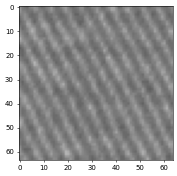

tf.Tensor(
[[[144. 144. 144.]
  [122. 122. 122.]
  [112. 112. 112.]
  ...
  [111. 111. 111.]
  [126. 126. 126.]
  [137. 137. 137.]]

 [[153. 153. 153.]
  [125. 125. 125.]
  [121. 121. 121.]
  ...
  [113. 113. 113.]
  [116. 116. 116.]
  [133. 133. 133.]]

 [[146. 146. 146.]
  [131. 131. 131.]
  [130. 130. 130.]
  ...
  [110. 110. 110.]
  [113. 113. 113.]
  [127. 127. 127.]]

 ...

 [[151. 151. 151.]
  [141. 141. 141.]
  [126. 126. 126.]
  ...
  [114. 114. 114.]
  [107. 107. 107.]
  [125. 125. 125.]]

 [[135. 135. 135.]
  [132. 132. 132.]
  [142. 142. 142.]
  ...
  [103. 103. 103.]
  [ 98.  98.  98.]
  [115. 115. 115.]]

 [[129. 129. 129.]
  [139. 139. 139.]
  [154. 154. 154.]
  ...
  [108. 108. 108.]
  [102. 102. 102.]
  [113. 113. 113.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


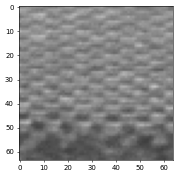

tf.Tensor(
[[[143. 143. 143.]
  [145. 145. 145.]
  [147. 147. 147.]
  ...
  [136. 136. 136.]
  [118. 118. 118.]
  [112. 112. 112.]]

 [[171. 171. 171.]
  [166. 166. 166.]
  [165. 165. 165.]
  ...
  [130. 130. 130.]
  [117. 117. 117.]
  [122. 122. 122.]]

 [[159. 159. 159.]
  [154. 154. 154.]
  [155. 155. 155.]
  ...
  [153. 153. 153.]
  [156. 156. 156.]
  [154. 154. 154.]]

 ...

 [[ 98.  98.  98.]
  [ 94.  94.  94.]
  [ 99.  99.  99.]
  ...
  [ 94.  94.  94.]
  [ 96.  96.  96.]
  [ 93.  93.  93.]]

 [[105. 105. 105.]
  [102. 102. 102.]
  [ 96.  96.  96.]
  ...
  [ 80.  80.  80.]
  [ 92.  92.  92.]
  [ 92.  92.  92.]]

 [[116. 116. 116.]
  [ 97.  97.  97.]
  [ 94.  94.  94.]
  ...
  [ 77.  77.  77.]
  [ 85.  85.  85.]
  [ 86.  86.  86.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


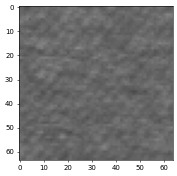

tf.Tensor(
[[[ 97.  97.  97.]
  [100. 100. 100.]
  [ 88.  88.  88.]
  ...
  [ 98.  98.  98.]
  [ 89.  89.  89.]
  [ 94.  94.  94.]]

 [[104. 104. 104.]
  [101. 101. 101.]
  [ 90.  90.  90.]
  ...
  [ 91.  91.  91.]
  [ 93.  93.  93.]
  [ 99.  99.  99.]]

 [[104. 104. 104.]
  [101. 101. 101.]
  [ 98.  98.  98.]
  ...
  [106. 106. 106.]
  [105. 105. 105.]
  [107. 107. 107.]]

 ...

 [[118. 118. 118.]
  [119. 119. 119.]
  [101. 101. 101.]
  ...
  [ 90.  90.  90.]
  [ 84.  84.  84.]
  [ 94.  94.  94.]]

 [[110. 110. 110.]
  [107. 107. 107.]
  [102. 102. 102.]
  ...
  [ 93.  93.  93.]
  [ 96.  96.  96.]
  [100. 100. 100.]]

 [[107. 107. 107.]
  [ 94.  94.  94.]
  [ 97.  97.  97.]
  ...
  [102. 102. 102.]
  [ 99.  99.  99.]
  [ 99.  99.  99.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
-----------------------------


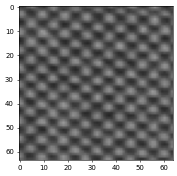

tf.Tensor(
[[[ 68.  68.  68.]
  [ 61.  61.  61.]
  [ 70.  70.  70.]
  ...
  [ 48.  48.  48.]
  [ 61.  61.  61.]
  [ 80.  80.  80.]]

 [[ 86.  86.  86.]
  [ 80.  80.  80.]
  [ 72.  72.  72.]
  ...
  [ 67.  67.  67.]
  [ 63.  63.  63.]
  [ 68.  68.  68.]]

 [[127. 127. 127.]
  [123. 123. 123.]
  [ 90.  90.  90.]
  ...
  [103. 103. 103.]
  [ 82.  82.  82.]
  [ 63.  63.  63.]]

 ...

 [[118. 118. 118.]
  [103. 103. 103.]
  [ 67.  67.  67.]
  ...
  [124. 124. 124.]
  [ 94.  94.  94.]
  [ 65.  65.  65.]]

 [[130. 130. 130.]
  [109. 109. 109.]
  [ 77.  77.  77.]
  ...
  [106. 106. 106.]
  [ 91.  91.  91.]
  [ 80.  80.  80.]]

 [[105. 105. 105.]
  [ 97.  97.  97.]
  [ 81.  81.  81.]
  ...
  [ 67.  67.  67.]
  [ 80.  80.  80.]
  [ 94.  94.  94.]]], shape=(64, 64, 3), dtype=float32)
tf.Tensor([0.], shape=(1,), dtype=float32)
-----------------------------


KeyboardInterrupt: 

In [165]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi']     = 50

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(0, len(images)):
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.show()
        print(images[i])
        print(labels[i])
        print("-----------------------------")
    

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(1, activation='sigmoid') # reports inflated acc and tiny loss values
#   layers.Dense(1)

])



In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


model.summary()

In [ ]:
epochs=15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size = 32,

)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

In [ ]:
# cwd = os.getcwd()
model.save("inspection_model")

#model.save_weights("inspection_weights")

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
  ]
)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(1, activation='sigmoid')
#   layers.Dense(1)
])



In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


model.summary()

In [ ]:
epochs=15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size = 32,

)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save("inspection_model_aug")


In [ ]:
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

In [ ]:
path = "C:/Users/schof/LeedsUni/personalproject/test_data/defect/defect_0.png"

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

In [ ]:
path = "C:/Users/schof/LeedsUni/personalproject/test_data/defect/defect_1.png"

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

In [ ]:
path = "C:/Users/schof/LeedsUni/personalproject/test_data/normal/normal_0.png"

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

In [ ]:
path = "C:/Users/schof/LeedsUni/personalproject/test_data/normal/normal_1.png"


cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)

p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

In [ ]:
# dad got an accarcy of 93% on inspections machines without ai

In [3]:
# loading 


reconstructed_model = keras.models.load_model("inspection_model")


In [166]:

result = reconstructed_model.evaluate(test_ds)

dict(zip(reconstructed_model.metrics_names, result))

18/18 [==============================] - 1s 46ms/step - loss: 0.0659 - accuracy: 0.9894


{'loss': 0.06593700498342514, 'accuracy': 0.9893617033958435}

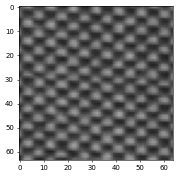

CNN output: [[0.01232016]]
This image most likely belongs to defect with a 98.77 percent confidence.
inference took: 0.09644839999964461 ms


In [177]:
path = "C:/Users/schof/LeedsUni/personalproject/test_data/defect/defect_20.png"

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()
predictions = reconstructed_model.predict(img_array)
timeTaken = time.perf_counter() - start

# score = tf.nn.sigmoid(predictions[0])

p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

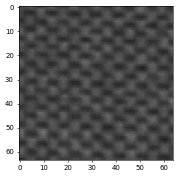

CNN output: [[0.9981036]]
This image most likely belongs to normal with a 99.81 percent confidence.
inference took: 0.15319909999379888 ms


In [206]:
path = "C:/Users/schof/LeedsUni/personalproject/tiles/normal/0001_000_00_7.png"

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

start = time.perf_counter()
predictions = reconstructed_model.predict(img_array)
timeTaken = time.perf_counter() - start

# score = tf.nn.sigmoid(predictions[0])

p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("inference took:", timeTaken,"ms")

Have to change batchsize to properly inspect, not needed if data isnt shuffled

In [293]:
test_ds = keras.utils.image_dataset_from_directory(
    directory='test_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=1,
    image_size=(img_height, img_width),
    shuffle=True
)

Found 564 files belonging to 2 classes.


In [294]:
model = reconstructed_model

preds = model.predict(test_ds,batch_size = 1,
verbose=1)

individualPredicts = []

TP = 0
TN = 0
FP = 0
FN = 0

names = os.listdir("C:/Users/schof/LeedsUni/personalproject/test_data/defect/")
for name in names:
    path = "C:/Users/schof/LeedsUni/personalproject/test_data/defect/"+name
    img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
    )
                   
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    p_class = int(np.rint(predictions[0]))
    individualPredicts.append(p_class)
    
    if p_class == 0:
        TP = TP + 1
    else:
        FP = FP + 1
        
    
    
    
names = os.listdir("C:/Users/schof/LeedsUni/personalproject/test_data/normal/")
for name in names:
    path = "C:/Users/schof/LeedsUni/personalproject/test_data/normal/"+name
    img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
    )
                   
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    p_class = int(np.rint(predictions[0]))
    individualPredicts.append(p_class)
    
    if p_class == 1:
        TN = TN + 1
    else:
        FN = FN + 1


# print(preds)
# print(individualPredicts)
print(TP, FP)
print(FN, TN)



564/564 [==============================] - 4s 8ms/step
87 1
5 471


In [295]:
predictions = []
targets  = []

start = time.perf_counter()

for image, target in test_ds:
    prediction = model.predict(image)
    targets.append(tf.get_static_value(target)[0][0])
    predictions.append(int(np.rint(prediction[0])))
    
taken = time.perf_counter() - start

print("time using single prediction:", taken)



time using single prediction: 72.73443630000111


[[ 87   1]
 [  5 471]]


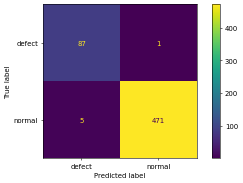

In [296]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(targets, predictions)
print(cm)



disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
disp.plot()
plt.show()



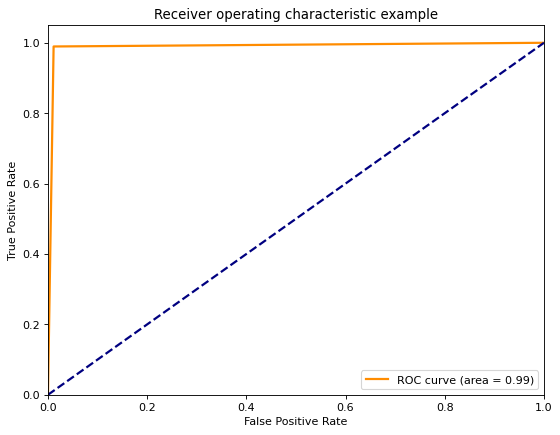

In [297]:
# y = np.concatenate([y for x, y in test_ds], axis=0)
# print(y)


fpr, tpr, _ = metrics.roc_curve(targets, predictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(8, 6), dpi=80)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [298]:
from sklearn.metrics import classification_report
 

print(classification_report(targets, predictions))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97        88
         1.0       1.00      0.99      0.99       476

    accuracy                           0.99       564
   macro avg       0.97      0.99      0.98       564
weighted avg       0.99      0.99      0.99       564



In [309]:

result = reconstructed_model.evaluate(all_ds)

dict(zip(reconstructed_model.metrics_names, result))

114216/114216 [==============================] - 733s 6ms/step - loss: 0.0435 - accuracy: 0.9900


{'loss': 0.043530236929655075, 'accuracy': 0.9899576306343079}

In [4]:
all_ds = keras.utils.image_dataset_from_directory(
    directory='tiles/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)

Found 114216 files belonging to 2 classes.


In [312]:
predictions = reconstructed_model.predict(all_ds)


roundedPredictions = []
for p in predictions:
    roundedPredictions.append(int(np.rint(p[0])))

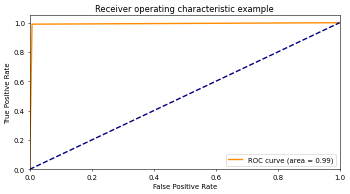

In [316]:
targets = np.concatenate([targets for features, targets in all_ds], axis=0)

fpr, tpr, _ = metrics.roc_curve(targets, roundedPredictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[[   902      7]
 [  1140 112167]]


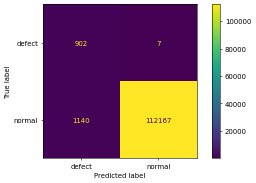

In [315]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

targets = np.concatenate([targets for features, targets in all_ds], axis=0)


cm = confusion_matrix(targets, roundedPredictions)
print(cm)



disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
disp.plot()
plt.show()

# With confidence 0.05 cutoff

In [11]:
predictions = reconstructed_model.predict(all_ds)

print("predictions done")



predictions done


In [32]:
roundedPredictions = []
for p in predictions:
    p_temp = 0
    if p[0] > 0.02:
        p_temp = 1
    roundedPredictions.append(p_temp)

[[   837     72]
 [   342 112965]]


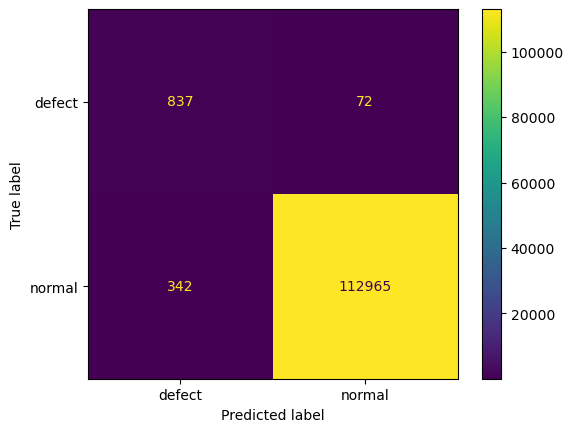

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

targets = np.concatenate([targets for features, targets in all_ds], axis=0)


cm = confusion_matrix(targets, roundedPredictions)
print(cm)



disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_ds.class_names)
disp.plot()
plt.show()

shuffel Off

In [304]:
test_ds = keras.utils.image_dataset_from_directory(
    directory='test_data/',
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)

Found 564 files belonging to 2 classes.


In [305]:

start = time.perf_counter()
predictions = reconstructed_model.predict(test_ds)


roundedPredictions = []
for p in predictions:
    roundedPredictions.append(int(np.rint(p[0])))
    
taken = time.perf_counter() - start

print("time taken using batch prediction:", taken)


time taken using batch prediction: 2.359129300049972


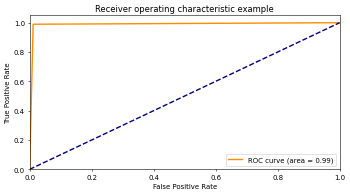

In [306]:
targets = np.concatenate([targets for features, targets in test_ds], axis=0)

fpr, tpr, _ = metrics.roc_curve(targets, roundedPredictions)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

[[ 87   1]
 [  5 471]]


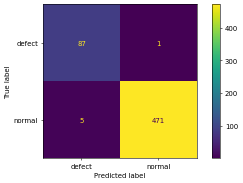

In [307]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(targets, roundedPredictions)
print(cm)



disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_ds.class_names)
disp.plot()
plt.show()

Checking opencv conversion

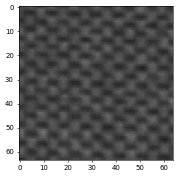

CNN output: [[0.9981036]]
This image most likely belongs to normal with a 99.81 percent confidence.
TensorFlow image prediction:  0.9981036
OpenCv image prediction:  0.9981036


In [308]:
path = "C:/Users/schof/LeedsUni/personalproject/tiles/normal/0001_000_00_7.png"

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)

cv_img = cv2.imread(path)
plt.imshow(cv_img)
plt.show() 


img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = reconstructed_model.predict(img_array)


p_class = class_names[int(np.rint(predictions[0]))]
confidence = predictions[0][0]
if int(np.rint(predictions[0])) == 0:
       confidence = 1 - predictions[0][0]
       

print("CNN output:", predictions)
    
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(p_class, 100 * confidence)
)

print("TensorFlow image prediction: ", predictions[0][0])


tileImRGB = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
tensor = tf.convert_to_tensor(tileImRGB, dtype=tf.float32)
tensor = tf.expand_dims(tensor, 0)

predictions = reconstructed_model.predict(tensor)
print("OpenCv image prediction: ", predictions[0][0])

